# Iteration 3: Propulsion

In [1]:
from unyt import km, m, mm, inch, g, kg, hr, minute, s, degree, radian, volt
import numpy as np
from matplotlib import pyplot as plt
from math import pi as π
%matplotlib inline

In [2]:
rpm = minute**-1

In [3]:
ρ = 1.225*kg/m**3 # air density
μinf = 1.81e-5*kg/(m*s) # viscosity of air

Goals:
- Use more accurate weight estimate
- Increase the AR a little (13 or something)
- Decrease air speed

![iteration_3-freecad-screenshot](iteration_3-freecad-screenshot.png)

## Initial Design

Increased wingspan from 2850 to 3050.

In [4]:
b = 3050*mm # wingspan
c = 230*mm # chord

In [5]:
S = b*c # wing area
AR = b**2/S

In [6]:
AR

unyt_quantity(13.26086957, '(dimensionless)')

## Weight Estimate

Weight stimate lowered from 3700 to 2340.

In [7]:
W = 2340*g # weight

![iteration_3-weight-tabulation](iteration_3-weight-tabulation.png)

## Airfoil Selection

Cruise speed lowered from 45 to 30.

In [8]:
V = 30*km/hr # cruise speed

In [9]:
CL = (2*W)/(ρ*V**2*S)

In [10]:
Re = (ρ*V*c)/μinf
round(Re.to_value(), -3)

130000.0

![clarky-cl-v-alpha](clarky-cl-v-alpha.png)

From bottom left up: Blue = 50,000  Orange = 100,000  Green = 200,000

In [11]:
α0 = -3.75*degree
Clα = 1.05
e = 0.8

In [12]:
CLα = Clα/(1+(Clα/(π*e*AR)))

In [13]:
CL_unitless = CL.to_value('s**2/m')

In [14]:
α = α0+((CL_unitless/CLα)*radian)
α

unyt_quantity(0.66417137, 'degree')

![clarky-cl-cd-v-alpha](clarky-cl-cd-v-alpha.png)

The 0.1° α is better than -0.4, but still not great. I do think I may be understimating the weight and probably overestimating the wing's 3D efficiency (currently 80%). I'll maybe come back to this.

In [15]:
CLmax = 1.4*s**2/m
Vstall = np.sqrt((2*W)/(ρ*S*CLmax))
print(f"Cruise speed: {V.to('m/s'):.2f}, Stall speed: {Vstall:.2f}")

Cruise speed: 8.33 m/s, Stall speed: 1.97 m/s


Excellent! I feel like I'm doing something wrong because these results are way too comfortable.

## Wing Loading and Thrust to Weight Ratio

In [16]:
WCL = W/(S**(3/2))
print(f"Wing loading: {WCL.to('kg/m**3'):.2f}")

Wing loading: 3.98 kg/m**3


Carlos Montalvo's WCL ballpark table converted from oz/ft^3 to SI units.

| Type of Aircraft | WCL (kg/m^3) |
| --- | --- |
| Gliders | under 4 |
| Trainers | 5-7 |
| Sport Aerobatic | 8-10 |
| Racers | 11-13 |
| Scale | over 15 |

Ok so oz/ft^3 -> kg/m^3 is apparently nearly 1:1 for these values.

Anyway, our 3.98 is OK.

In [17]:
TtoW = 1.1

As per 'Aircraft Flight Mechanics': T/W should be above 0.8 in all situations and above 1.2 to be safe with short runways. I did find other resources indicating a sub-.8 T/W is OK for gliders. However, it seems universally accepted that 1+ is necessary for 3D flight.

Because I do have future plans for high thrust takeoff with this design, I picked the above.

In [18]:
T = TtoW*W
print(f"{T.to('kg'):.2f}")

2.57 kg


## Propulsion system

To choose a propulsion system we'll start by calculating the max speed we need to be able to reach.

Assuming we want cruise speed to be 65% throttle:

In [19]:
Vmax = V/0.65
print(f"Max speed: {Vmax.to('m/s'):.2f}")

Max speed: 12.82 m/s


We can then plot the minimum propeller Pitch Y v rpm. (assuming a Pitch Y efficiency of .8.)

Text(0, 0.5, 'Minimum Pitch Y (inch)')

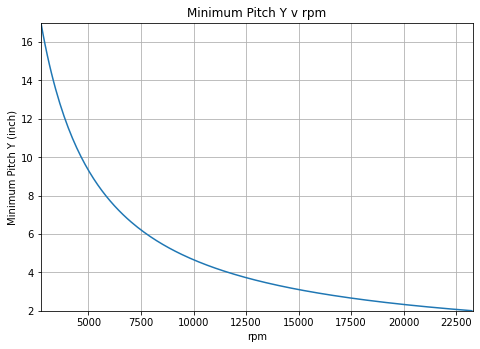

In [20]:
pitchYe = 0.65
minPitchYPerMinute = (Vmax*(1/pitchYe)).to('inch/min')

minPitchY, maxPitchY = 2*inch, 17*inch
minRpm, maxRpm = minPitchYPerMinute/maxPitchY, minPitchYPerMinute/minPitchY
x = np.arange(minRpm, maxRpm, 100*rpm)
y = minPitchYPerMinute/x

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.grid(True)
ax.set_ylim([minPitchY, maxPitchY])
ax.set_xlim([minRpm, maxRpm])
ax.plot(x, y)
ax.set_title('Minimum Pitch Y v rpm')
ax.set_xlabel('rpm')
ax.set_ylabel('Minimum Pitch Y (inch)')

Or more usefully: the minimum Pitch Y versus the Kv rating for different LiPo cell compositions.

I also ran MotoCalc. You can find the results (and parameters I used) in [iteration_3-motocalc-results.txt](iteration_3-motocalc-results.txt) (and the project in [iteration_3-motocalc-project.txt](iteration_3-motocalc-project.txt)). 

The top 4 recommendations are the following (also plotted below):

| Kv | Cell Composition | Pitch Y |
| --- | --- | --- |
| 325 | 5S | 7 |
| 480 | 4S | 6 |
| 330 | 6S | 7 |
| 250 | 5S | 11 |

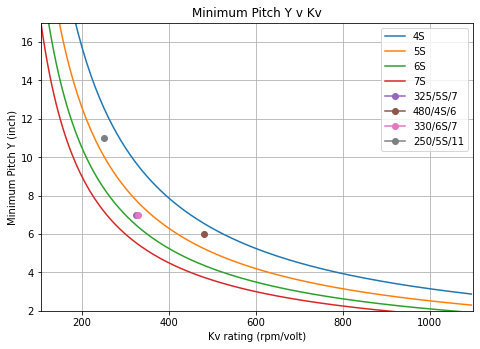

In [21]:
LiPo4SVoltage = 3.7*volt*4
LiPo5SVoltage = 3.7*volt*5
LiPo6SVoltage = 3.7*volt*6
LiPo7SVoltage = 3.7*volt*7

minKv, maxKv = minPitchYPerMinute/(maxPitchY*LiPo7SVoltage), minPitchYPerMinute/(minPitchY*LiPo7SVoltage)+200*(rpm/volt)
x = np.arange(minKv, maxKv, 5*(rpm/volt))
y4S = minPitchYPerMinute/(x*LiPo4SVoltage)
y5S = minPitchYPerMinute/(x*LiPo5SVoltage)
y6S = minPitchYPerMinute/(x*LiPo6SVoltage)
y7S = minPitchYPerMinute/(x*LiPo7SVoltage)

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.grid(True)
ax.set_ylim([minPitchY, maxPitchY])
ax.set_xlim([minKv, maxKv])
ax.plot(x, y4S, label = "4S")
ax.plot(x, y5S, label = "5S")
ax.plot(x, y6S, label = "6S")
ax.plot(x, y7S, label = "7S")
plt.plot([325], [7], marker='o', label = "325/5S/7")
plt.plot([480], [6], marker='o', label = "480/4S/6")
plt.plot([330], [7], marker='o', label = "330/6S/7")
plt.plot([250], [11], marker='o', label = "250/5S/11")
ax.set_title('Minimum Pitch Y v Kv')
ax.set_xlabel('Kv rating (rpm/volt)')
ax.set_ylabel('Minimum Pitch Y (inch)')
ax.legend()

In conculsion: I'm aiming for a minimum 250/4S/12, 300/4S/8, 450/4S/6 but preferably 5 or 6S.

As for prop diameter: any combination of the above that gives me at least 2.6 kg of thrust.

### Propulsion system component selection

Possible combinations:

#### 1. `Turnigy G60 Brushless Outrunner 500kv (.60 Glow)`

https://hobbyking.com/en_us/turnigy-g60-brushless-outrunner-500kv-60-glow.html

Kv: **500**  
Max current: **65A**  
Price: **€57.41**  
Weight: **360g**  

5S LiPo (9250 rpm) + 13x8 prop: **869W 47A 2.85kg**

Conclusion: OK

#### 2. `PROPDRIVE v2 5060 380KV Brushless Outrunner Motor`

https://hobbyking.com/en_us/propdrive-v2-5060-380kv-brushless-outrunner-motor.html

Kv: **380**  
Max current: **90A**  
Price: **€54.71**  
Weight: **438g**  

From reviews:
6S LiPo (8436 rpm) + 15x12 prop: **1110W 50A ???kg**  
*thrust probably higher than the G60 (higher wattage)*

Conclusion: OK

#### 3. `Turnigy G46 Brushless Outrunner 670kv (.46 Glow)`

https://hobbyking.com/en_us/propdrive-v2-5060-380kv-brushless-outrunner-motor.html

Kv: **670**  
Max current: **40A**  
Price: **€52.19**  
Weight: **303g**  

From reviews:  
5S LiPo (12395 rpm) + 12x8 prop: **697W 43A 2.9kg**  
5S LiPo (12395 rpm) + 13x6 prop: **1000W 54A 3.1kg**  
*I don't quite get how current draw is exceeding the max here...*

Conclusion: maybe OK, on the uncomfortable side with regards to the max current rating

#### 4. `PROPDRIVE v2 5050 580KV Brushless Outrunner Motor`

https://hobbyking.com/en_us/propdrive-v2-5050-580kv-brushless-outrunner-motor.html

Kv: **580**  
Max current: **90A**  
Price: **€49.58**  
Weight: **331g**  

From reviews:  
6-7S? LiPo (14247 rpm) + 14x7 prop: **1298W 69A ???kg**  

Conclusion: OK

#### 5. `PROPDRIVE v2 4258 500KV Brushless Outrunner Motor`

https://hobbyking.com/en_us/propdrive-v2-4258-500kv-brushless-outrunner-motor.html

Kv: **500**  
Max current: **60A**  
Price: **€46.10**  
Weight: **300g**  

4S LiPo (&nbsp; 7400 rpm) + 15x8 prop: &nbsp; **&nbsp; 421W 28.5A ???kg**  
5S LiPo (&nbsp; 9250 rpm) + 15x8 prop: &nbsp; **&nbsp; 760W 41.1A ???kg**  
6S LiPo (11100 rpm) + 15x8 prop: &nbsp; **1256W 56.6A ???kg**  
~~6S LiPo (11100 rpm) + 16x10 prop: **&nbsp; 669W 45.2A ???kg**~~  
4S LiPo (&nbsp; 7400 rpm) + 16x10 prop: **&nbsp; 669W 45.2A ???kg**  
*I used the wrong crossed out rating for the decisions below, so these are not entirely accurate. See iteration 4 for the right version.*

Conclusion: OK

#### 6. `Turnigy Aerodrive SK3 - 5055-380KV Brushless Outrunner Motor`

https://hobbyking.com/en_us/outrunner-for-1450mm-spitfire-inc-prop-shaft-x-shared-part.html

Kv: **380**  
Max current: **65A**  
Price: **€42.73**  
Weight: **422g**  

Conclusion: maybe OK

Comparing all of the above seems a bit arbitrary, and I still have a lot to learn.

Regardless I'll be going with #5: the `PROPDRIVE v2 4258 500KV Brushless Outrunner Motor` (€46.10) with 6S battery and 16x10 prop. It is the second cheapest shippable option, the lightest motor, and while using a larger prop and rpm, it achieves a lower power draw (669v869) than #1 (while likely providing more thrust). 

Also, all reviews are positive and `PROPDRIVE`'s technical specifications seems more complete than Turnigy's, which does inspire more confidence.

## Stability and Control, Center of Mass, Aerodynamic Center and Static Margin

I won't be calculating any of the stability paramters right now for two reasons:

- I will be 3D printing the fuselage, which means I have a lot of freedom with regards to weight distribution and dihedral.
- I don't have any experience building wings, and to test out some of the weight distribution ideas that I have (like putting batteries in the front section of the wing), I feel like I *have* to build first.

## Final parts selection

### Motor

As outlined above, this will be the [`PROPDRIVE v2 4258 500KV Brushless Outrunner Motor`](https://hobbyking.com/en_us/propdrive-v2-4258-500kv-brushless-outrunner-motor.html) (€46.10).

### ESC

Assuming a 10% higher ESC power rating than the 60A max motor current (we're only planning on 45.2A anyway), we need a 66A ESC.

I decided on the [`YEP 80A (2~6S) SBEC`](https://hobbyking.com/en_us/yep-80a-2-6s-sbec-brushless-speed-controller.html). It's well rated, can handle more than enough current, and has a nice 6A\@5.5V BEC.

### Battery

Our max power draw is approximately 66A. This means we're looking for a C rating of at least:  
*Or double that to be safe, as per https://www.rchelicopterfun.com/lipo-batteries.html#lipo3*

- 3000mAh: 22 (44)
- 3300mAh: 20 (40)
- 3700mAh: 18 (36)
- 4000mAh: 17 (34)

Motocalc recommends a 2100 2P = 4200 pack system to get half an hour of flight time.

I decided to go with the [`Turnigy nano-tech 4000mAh 6S 35~70C`](https://hobbyking.com/en_us/turnigy-nano-tech-4000mah-6s-35-70c-lipo-pack-w-xt-90.html). I was considering going with two lower capacity packs to integrate into the wing, however this would be difficult because the usual minimum thickness of a 6S pack is about 45mm. Also, this pack has a relatively high capacity-to-weight ratio of 6.61mAh/g, which is better than for example the [`Turnigy Heavy Duty 4000mAh 6S 60C`](https://hobbyking.com/en_us/turnigy-heavy-duty-4000mah-6s-60c-lipoly-battery-pack-xt90.html) at 5.87mAh/g. I'm noticedI underestimated all power components quite a bit, so the relatively lighter weight will come in handy.

### Prop

The [`TGS Precision Sport Propeller 17x10`](https://hobbyking.com/en_us/tgs-precision-sport-propeller-17x10-1pc.html) look ok. I'm just now realizing how big 17 inches is. Since I need to do a new iteration with better weight estimates anyway I might also come back to this and try to pick a smaller prop diameter.